# Decoding ESG Risk Ratings: Insights into Financial Sector Sustainablilty by Using Machine Learning

### Johannes Weber (152023035) - September 11, 2025

# 0. Setup

## 0.1 Libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import randint, uniform
import seaborn as sns

import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colorbar as cbar
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import textwrap

import scipy.stats as stats

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## 0.2 Loading Dataset 

In [2]:
# Loading datasets
general_information = pd.read_csv("general_information.csv") 
environmental_pillar = pd.read_csv("environmental_pillar.csv")
social_pillar = pd.read_csv("social_pillar.csv")
governance_pillar = pd.read_csv("governance_pillar.csv")

In [3]:
# Joing data by "name"
esg_data_raw = general_information.merge(environmental_pillar, on="name", how="inner") \
.merge(social_pillar, on="name", how="inner") \
.merge(governance_pillar, on="name", how="inner") 

In [4]:
# Adding "id" column
esg_data_raw.insert(0, "id", range(1, len(esg_data_raw) + 1))

In [5]:
# Display the first few rows
esg_data_raw.head()

,id,name,headquarter,market_capitalization,emissions_policy,scope_1_estimated_total,scope_2_estimated_total,targets_emissions,resource_reduction_policy,waste_reduction_initiatives,...,csr_sustainability_committee,board_gender_diversity,executive_members_gender_diversity,succession_plan,tax_transparency_policy,sdg_goal_7,sdg_goal_8,sdg_goal_11,sdg_goals_12,sdg_goal_13
0,1,Taishin Financial Holding Co Ltd,TW,"$8,228",True,1936.0,27860.0,True,True,True,...,True,14.29%,33.33%,False,True,True,True,True,True,True
1,2,Turkiye Is Bankasi AS,TR,"$10,133",True,18333.0,51057.0,True,True,True,...,True,18.18%,15.38%,True,False,True,True,False,False,True
2,3,KB Financial Group Inc,KR,"$22,242",True,15018.0,123414.0,True,True,True,...,True,33.33%,13.33%,True,True,True,True,True,True,True
3,4,CIMB Group Holdings Bhd,MY,"$20,181",True,3077.0,84813.0,True,True,True,...,True,28.57%,17.65%,True,False,False,True,False,True,True
4,5,Chailease Holding Company Ltd,TW,"$6,694",True,25261.0,6505.0,True,True,True,...,True,11.11%,23.08%,True,True,True,True,True,True,True


# 1. Data Preparation

## 1.1 Overview

In [6]:
print(esg_data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 49 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     1144 non-null   int64  
 1   name                                   1144 non-null   object 
 2   headquarter                            1144 non-null   object 
 3   market_capitalization                  1142 non-null   object 
 4   emissions_policy                       1144 non-null   bool   
 5   scope_1_estimated_total                1044 non-null   float64
 6   scope_2_estimated_total                1044 non-null   float64
 7   targets_emissions                      1144 non-null   bool   
 8   resource_reduction_policy              1144 non-null   bool   
 9   waste_reduction_initiatives            1144 non-null   bool   
 10  targets_pollution                      1144 non-null   bool   
 11  targ

## 1.2 Data Types

### 1.2.1 Object to Integer

In [7]:
# Creating copy of raw data for further processing
esg_data = esg_data_raw.copy()

# Removing '$' and ',' from the column
esg_data['market_capitalization'] = esg_data['market_capitalization'].str.replace('[$,]', '', regex=True)
esg_data['market_capitalization'] = esg_data['market_capitalization'].astype('Int64')

# Check if the transformation worked correctly
esg_data['market_capitalization'].head()
#esg_data['market_capitalization'].dtype

0     8228
1    10133
2    22242
3    20181
4     6694
Name: market_capitalization, dtype: Int64

### 1.2.2 Object to Percentage

In [8]:
# Changing data types from object to float 
percentage_cols = ['esg_reporting_scope', 'board_gender_diversity', 'executive_members_gender_diversity']

# Removing "%" sign, converting to float, and dividing by 100 for each of the percentage columns
for col in percentage_cols:
    esg_data[col] = esg_data[col].str.replace('%', '', regex=False).astype(float) / 100

In [9]:
# Check if the transformation worked correctly
percentage_cols = ['esg_reporting_scope', 'board_gender_diversity', 'executive_members_gender_diversity']
esg_data[percentage_cols].dtypes
# esg_data[percentage_cols].head()

esg_reporting_scope                   float64
board_gender_diversity                float64
executive_members_gender_diversity    float64
dtype: object

## 1.3 Missing Values

In [10]:
# Total number of observations
total_obs = esg_data.shape[0]

# Missing count and percentage for each column
missing_counts = esg_data.isna().sum()
missing_percentage = (missing_counts / total_obs) * 100

# Summary for missing data
missing_summary = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percentage': missing_percentage})

# Only columns with at least one missing value
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0]
print(missing_summary)

                                    Missing_Count  Missing_Percentage
market_capitalization                           2            0.174825
scope_1_estimated_total                       100            8.741259
scope_2_estimated_total                       100            8.741259
esg_reporting_scope                           318           27.797203
executive_members_gender_diversity              7            0.611888


### 1.3.1 market_capitalization 

In [11]:
# Name of instiutions with missing values
missing_cap = esg_data[esg_data['market_capitalization'].isna()][['name', 'market_capitalization']]
print(missing_cap)

                                         name  market_capitalization
277   Corporacion Financiera de Desarrollo SA                   <NA>
1054                      Ithmaar Holding BSC                   <NA>


In [12]:
# The values are manually replaced by own values searched on the internet 
# Ithmaar Holding BSC: 573 (yahoo.finance, 12.02.2025)
# Corporacion Financiera de Desarrollo SA: Not avaiable

esg_data = esg_data[esg_data['name'] != 'Corporacion Financiera de Desarrollo SA']
esg_data.loc[esg_data['name'] == 'Ithmaar Holding BSC', 'market_capitalization'] = 573

#missing_cap = esg_data[esg_data['market_capitalization'].isna()][['name', 'market_capitalization']]
#print(missing_cap)

### 1.3.2 executive_members_gender_diversity

In [13]:
# Removing the 7 observations as they all have also missing values in esg_reporting_scope and three in scope_1_estimated_total/scope_2_estimated_total
esg_data = esg_data.dropna(subset=['executive_members_gender_diversity'])

# New number of observations
total_obs = esg_data.shape[0]
print("New total number of observations:", total_obs)

New total number of observations: 1136


### 1.3.3 esg_reporting_scope

In [14]:
# Removing variable from dataset
esg_data = esg_data.drop(columns=['esg_reporting_scope'])

### 1.3.4 scope_1_estimated_total and scope_2_estimated_total

In [15]:
# Predictors for Scope 1 (direct emissions)
scope1_bool_vars = [
    'emissions_policy', 
    'targets_emissions', 
    'resource_reduction_policy', 
    'waste_reduction_initiatives', 
    'targets_pollution', 
    'targets_waste', 
    'biodiversity_commitment', 
    'biodiversity_impact_reduction', 
    'environmental_investments_initiatives', 
    'environmental_products', 
    'environmental_partnerships']

impute_vars_scope1 = ['scope_1_estimated_total'] + scope1_bool_vars

# Predictors for Scope 2 (indirect emissions)
scope2_bool_vars = [
    'emissions_policy', 
    'targets_emissions', 
    'resource_reduction_policy', 
    'waste_reduction_initiatives', 
    'targets_pollution', 
    'environmental_investments_initiatives', 
    'renewable_clean_energy_products', 
    'sustainable_building _products', 
    'environmental_partnerships']

impute_vars_scope2 = ['scope_2_estimated_total'] + scope2_bool_vars

# Creating data subsets for each imputation 

df_impute_scope1 = esg_data[impute_vars_scope1].copy()
df_impute_scope2 = esg_data[impute_vars_scope2].copy()

# Converting boolean variables to numeric (True -> 1.0, False -> 0.0)
for col in scope1_bool_vars:
    df_impute_scope1[col] = df_impute_scope1[col].astype(float)
    
for col in scope2_bool_vars:
    df_impute_scope2[col] = df_impute_scope2[col].astype(float)

# Running IterativeImputer for each scope

iter_imputer1 = IterativeImputer(random_state=42, max_iter=30)
iter_imputer2 = IterativeImputer(random_state=42, max_iter=30)

# Imputing missing values for scope 1 variables
imputed_array_scope1 = iter_imputer1.fit_transform(df_impute_scope1)
df_imputed_scope1 = pd.DataFrame(imputed_array_scope1, columns=impute_vars_scope1)

# Imputing missing values for scope 2 variables
imputed_array_scope2 = iter_imputer2.fit_transform(df_impute_scope2)
df_imputed_scope2 = pd.DataFrame(imputed_array_scope2, columns=impute_vars_scope2)

# Updating original data with imputed emissions values
esg_data['scope_1_estimated_total'] = df_imputed_scope1['scope_1_estimated_total']
esg_data['scope_2_estimated_total'] = df_imputed_scope2['scope_2_estimated_total']

# Check if there are any remaining missing values 
print("Missing values after imputation for scope 1 emissions:")
print(esg_data['scope_1_estimated_total'].isna().sum())

print("Missing values after imputation for scope 2 emissions:")
print(esg_data['scope_2_estimated_total'].isna().sum())

Missing values after imputation for scope 1 emissions:
7
Missing values after imputation for scope 2 emissions:
7


In [16]:
# Filtering rows where either emissions column is missing
missing_obs = esg_data[
    esg_data['scope_1_estimated_total'].isna() | esg_data['scope_2_estimated_total'].isna()]
missing_obs.head(10)

,id,name,headquarter,market_capitalization,emissions_policy,scope_1_estimated_total,scope_2_estimated_total,targets_emissions,resource_reduction_policy,waste_reduction_initiatives,...,csr_sustainability_committee,board_gender_diversity,executive_members_gender_diversity,succession_plan,tax_transparency_policy,sdg_goal_7,sdg_goal_8,sdg_goal_11,sdg_goals_12,sdg_goal_13
1136,1137,AP Alternative Portfolio AG,CH,26,False,NaN,NaN,False,False,False,...,False,0.0000,0.0000,False,False,False,False,False,False,False
1137,1138,Garovaglio y Zorraquin SA,AR,7,False,NaN,NaN,False,True,True,...,False,0.0000,0.0000,True,False,False,False,False,False,False
1138,1139,Airesis SA,CH,3,False,NaN,NaN,False,False,False,...,False,0.0000,0.0000,False,False,False,False,False,False,False
1140,1141,Dukhan Bank QPSC,QA,5413,False,NaN,NaN,False,False,False,...,False,0.0000,0.1250,False,False,False,False,False,False,False
1141,1142,Grand Parade Investments Ltd,ZA,82,False,NaN,NaN,False,False,False,...,True,0.2857,0.0000,True,False,False,False,False,False,False
1142,1143,California First Leasing Corp,US,216,False,NaN,NaN,False,False,False,...,False,0.0000,0.3333,False,False,False,False,False,False,False
1143,1144,Bank of Greece,GR,297,True,NaN,NaN,False,True,True,...,False,0.0833,0.2069,False,False,False,False,False,False,False


In [17]:
# Removing the remaining missing values
esg_data = esg_data.dropna(subset=['scope_1_estimated_total', 'scope_2_estimated_total'])
print("\nData shape after removing observations with missing emissions:", esg_data.shape)


Data shape after removing observations with missing emissions: (1129, 48)


# 2. Exploratory Data Analysis

## 2.1 Market Capitalization and Countries

In [18]:
# Loading world countries dataset
world = gpd.read_file("countries.geojson")

# Getting ISO A2 codes
if 'ISO3166-1-Alpha-2' in world.columns:
    world = world.rename(columns={'ISO3166-1-Alpha-2': 'iso_a2'})
    world['iso_a2'] = world['iso_a2'].str.strip().str.upper()
else:
    raise ValueError("Expected 'ISO3166-1-Alpha-2' column not found in world GeoJSON.")

# Counting of observations per country
country_counts = esg_data['headquarter'].value_counts().reset_index()
country_counts.columns = ['iso_a2', 'count']
print("Country counts from esg_data:")
print(country_counts.head(20))

# Merge counts onto geometries
world_counts = world.merge(country_counts, on='iso_a2', how='left')
world_counts['count'] = world_counts['count'].fillna(0).astype(int)

Country counts from esg_data:
   iso_a2  count
0      US    339
1      CN    115
2      IN     82
3      GB     54
4      JP     44
5      AU     35
6      CA     30
7      TH     22
8      AE     20
9      CH     20
10     IT     18
11     TW     15
12     MY     15
13     ID     14
14     DE     14
15     KR     14
16     TR     13
17     HK     12
18     SE     12
19     ZA     11


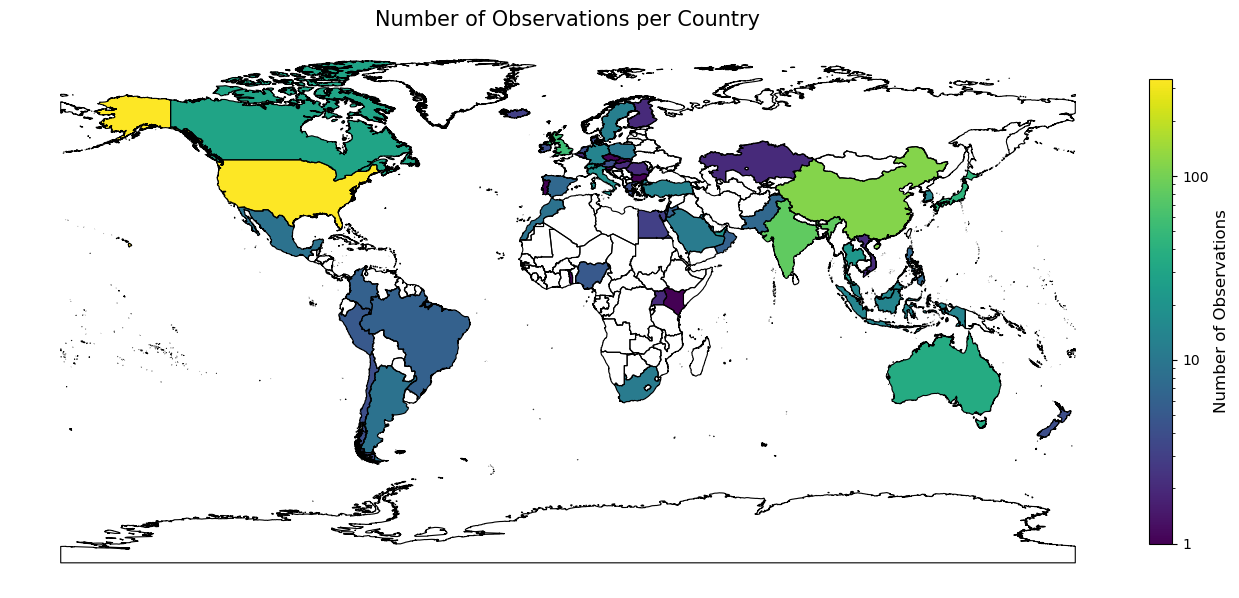

In [19]:
# Creating figure
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
custom_cmap = plt.colormaps["viridis"]

# Improving contrast for small values
vmin = max(1, world_counts['count'].min())  
vmax = world_counts['count'].max()
norm = LogNorm(vmin=vmin, vmax=vmax)

# Plotting map
world_counts.boundary.plot(ax=ax, linewidth=0.8, edgecolor='black')

# Plot filled countries with observations
world_counts[world_counts['count'] > 0].plot(
    column='count', ax=ax, cmap=custom_cmap, norm=norm, legend=False)

# Adjusting color bar 
sm = cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm._A = []  

cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.02, pad=0.02)
cbar.set_label("Number of Observations", fontsize=12)

cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))

ax.set_title("Number of Observations per Country", fontsize=15)
ax.set_axis_off()

plt.savefig("observations_map.png", dpi=500, bbox_inches="tight")
plt.show()

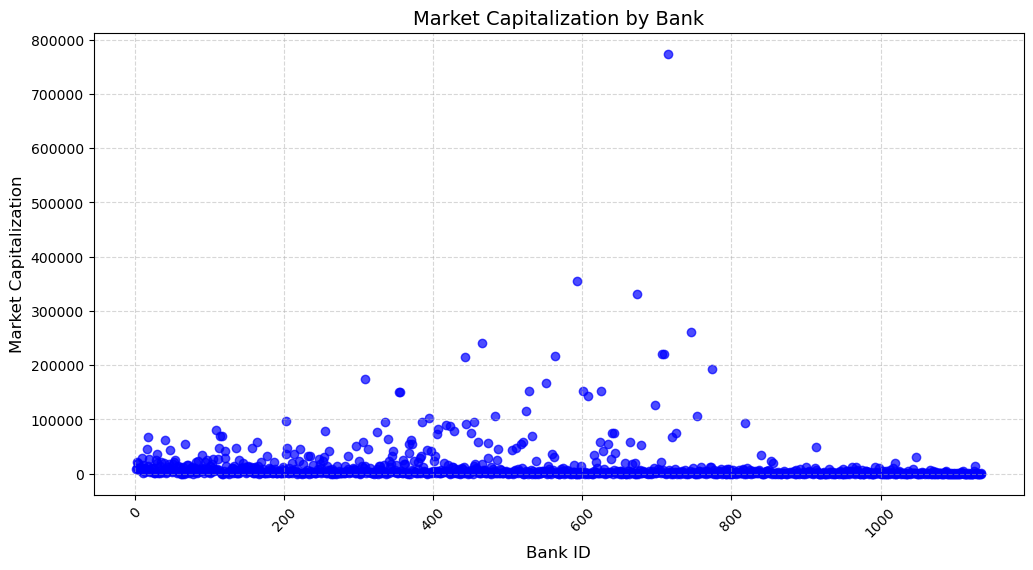

In [20]:
# Creating figure
plt.figure(figsize=(12, 6))

# Scatter plot
plt.scatter(esg_data["id"], esg_data["market_capitalization"], alpha=0.7, color="blue")
plt.xlabel("Bank ID", fontsize=12)
plt.ylabel("Market Capitalization", fontsize=12)
plt.title("Market Capitalization by Bank", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

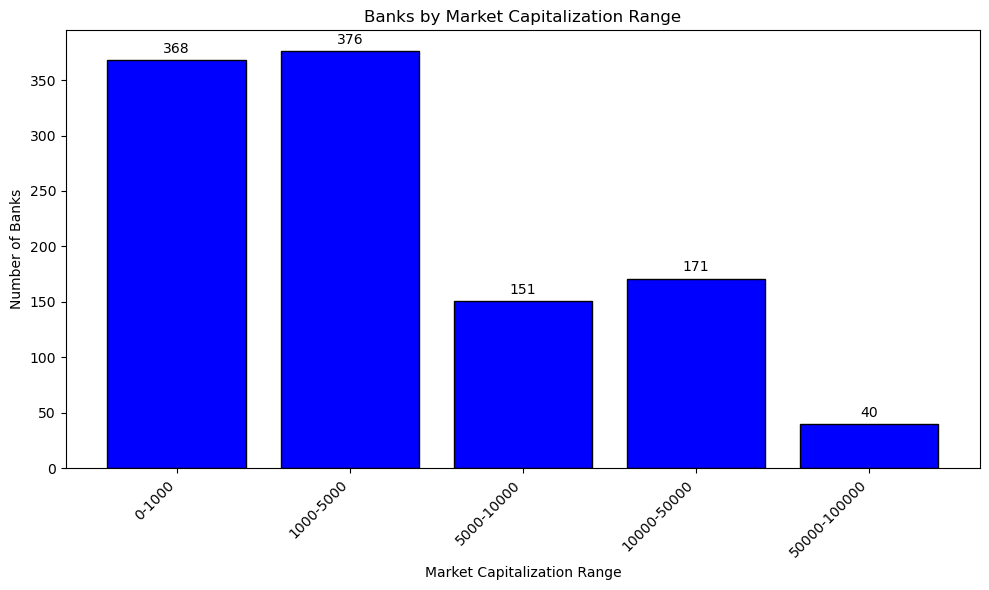

In [21]:
# Converting market capitalization to bins to reduce overfitting 
market_cap = esg_data['market_capitalization']

# Defining bin edges and labels
bins = [0, 1000, 5000, 10000, 50000, 100000]
labels = ["0-1000", "1000-5000", "5000-10000", "10000-50000", "50000-100000"]

# Assign string labels directly
esg_data['market_cap_bin'] = pd.cut(
    market_cap,
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Count how many observations fall into each bin
counts_market_cap = esg_data['market_cap_bin'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(counts_market_cap.index.astype(str), counts_market_cap.values, edgecolor='black', color='blue')

# Adding count for labels
for bar in bars:
    height = bar.get_height()
    plt.annotate(
        f'{int(height)}',
        xy=(bar.get_x() + bar.get_width()/2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center', va='bottom', color='black'
    )

plt.xlabel('Market Capitalization Range')
plt.ylabel('Number of Banks')
plt.title('Banks by Market Capitalization Range')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 2.2 Rating Distribution 

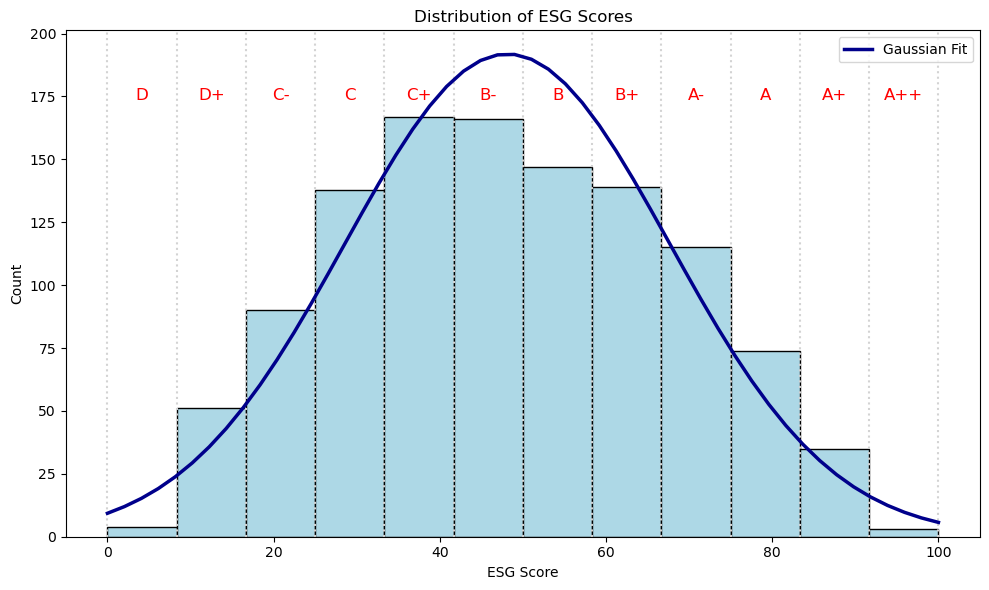

In [22]:
# Defining rating grade boundries
score_boundaries = [0, 8.33333, 16.66667, 25, 33.33333, 41.66667, 50, 58.33333, 66.66667, 75, 83.33333, 91.66667, 100]
grade_labels = ['D',  'D+', 'C-', 'C', 'C+', 'B-', 'B',  'B+', 'A-', 'A',  'A+', 'A++']

# Creating plot
plt.figure(figsize=(10, 6))
plt.xlabel('ESG Score')
plt.ylabel('Count')
plt.title('Distribution of ESG Scores')

# Bins = score_boundaries 
n, bins, patches = plt.hist(esg_data['esg_score'], bins=score_boundaries, color='lightblue', edgecolor='black')


# Drawing vertical lines for rating grades
for boundary in score_boundaries:
    plt.axvline(x=boundary, color='lightgray', linestyle=':')

# Creating rating grade labels
for i in range(len(score_boundaries) - 1):
    left_bound = score_boundaries[i]
    right_bound = score_boundaries[i + 1]
    x_mid = (left_bound + right_bound) / 2.0
    y_max = plt.ylim()[1]  
    plt.text(x_mid, y_max, grade_labels[i],
             ha='center', va='center', fontsize=12, color='red')

    
# Gaussian normal curve 
# Calculating mean and standard deviation of esg_score
mean = esg_data['esg_score'].mean()
std = esg_data['esg_score'].std()

# Generating and scaling the curve
x = np.linspace(0, 100)
pdf = stats.norm.pdf(x, mean, std)

total_obs = len(esg_data['esg_score'])
bin_width = score_boundaries[1] - score_boundaries[0]
pdf_scaled = pdf * total_obs * bin_width

# Showing plot
plt.plot(x, pdf_scaled, color='darkblue', label='Gaussian Fit', linewidth=2.5)
plt.legend()

plt.tight_layout()
plt.show()

## 2.3 Environmental Features

In [23]:
#print(esg_data.columns)

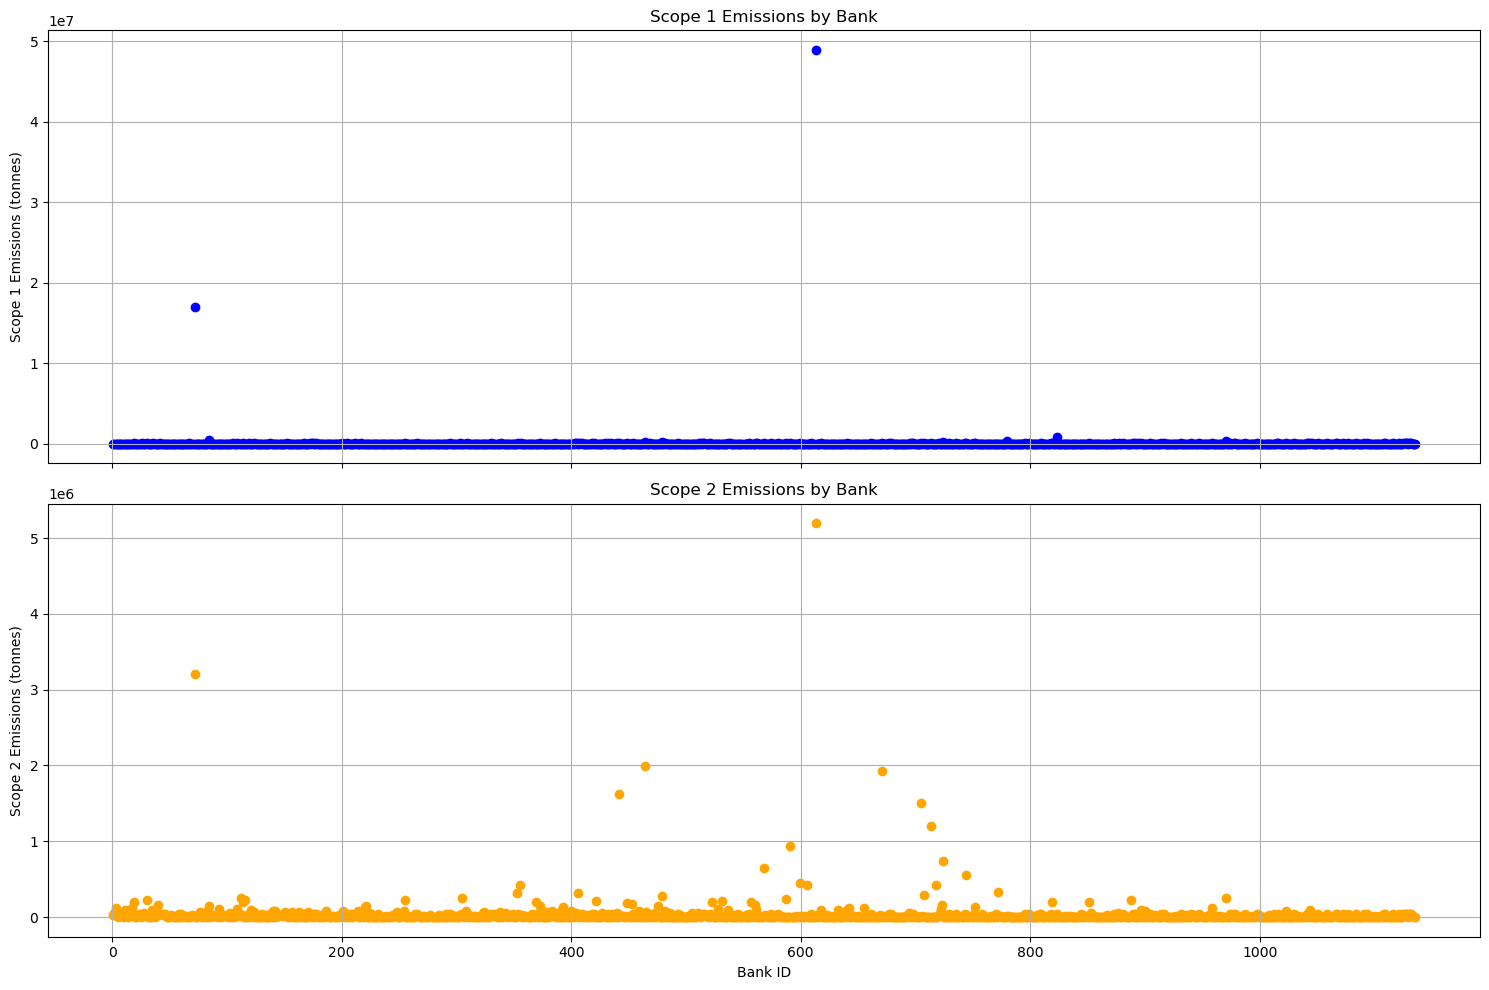

In [24]:
# Create a figure with 2 vertical subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

# Plot Scope 1 emissions
axes[0].scatter(esg_data['id'], esg_data['scope_1_estimated_total'], color='blue')
axes[0].set_ylabel('Scope 1 Emissions (tonnes)')
axes[0].set_title('Scope 1 Emissions by Bank')
axes[0].grid(True)

# Plot Scope 2 emissions
axes[1].scatter(esg_data['id'], esg_data['scope_2_estimated_total'], color='orange')
axes[1].set_xlabel('Bank ID')
axes[1].set_ylabel('Scope 2 Emissions (tonnes)')
axes[1].set_title('Scope 2 Emissions by Bank')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [25]:
# Removing two outliers, which show extremly high scope 1 and 2 emissions compared to the peers
print(esg_data[["id", "scope_1_estimated_total"]].sort_values("scope_1_estimated_total", ascending=False).head(5))

print(esg_data[["id", "scope_2_estimated_total"]].sort_values("scope_2_estimated_total", ascending=False).head(5))

esg_data = esg_data[~esg_data["id"].isin([613, 72])]

      id  scope_1_estimated_total
612  613               48906415.0
71    72               16929674.0
822  823                 882274.0
83    84                 471773.0
969  970                 379173.0
      id  scope_2_estimated_total
612  613                5194616.0
71    72                3207661.0
463  464                1998863.0
670  671                1929200.0
441  442                1628919.0


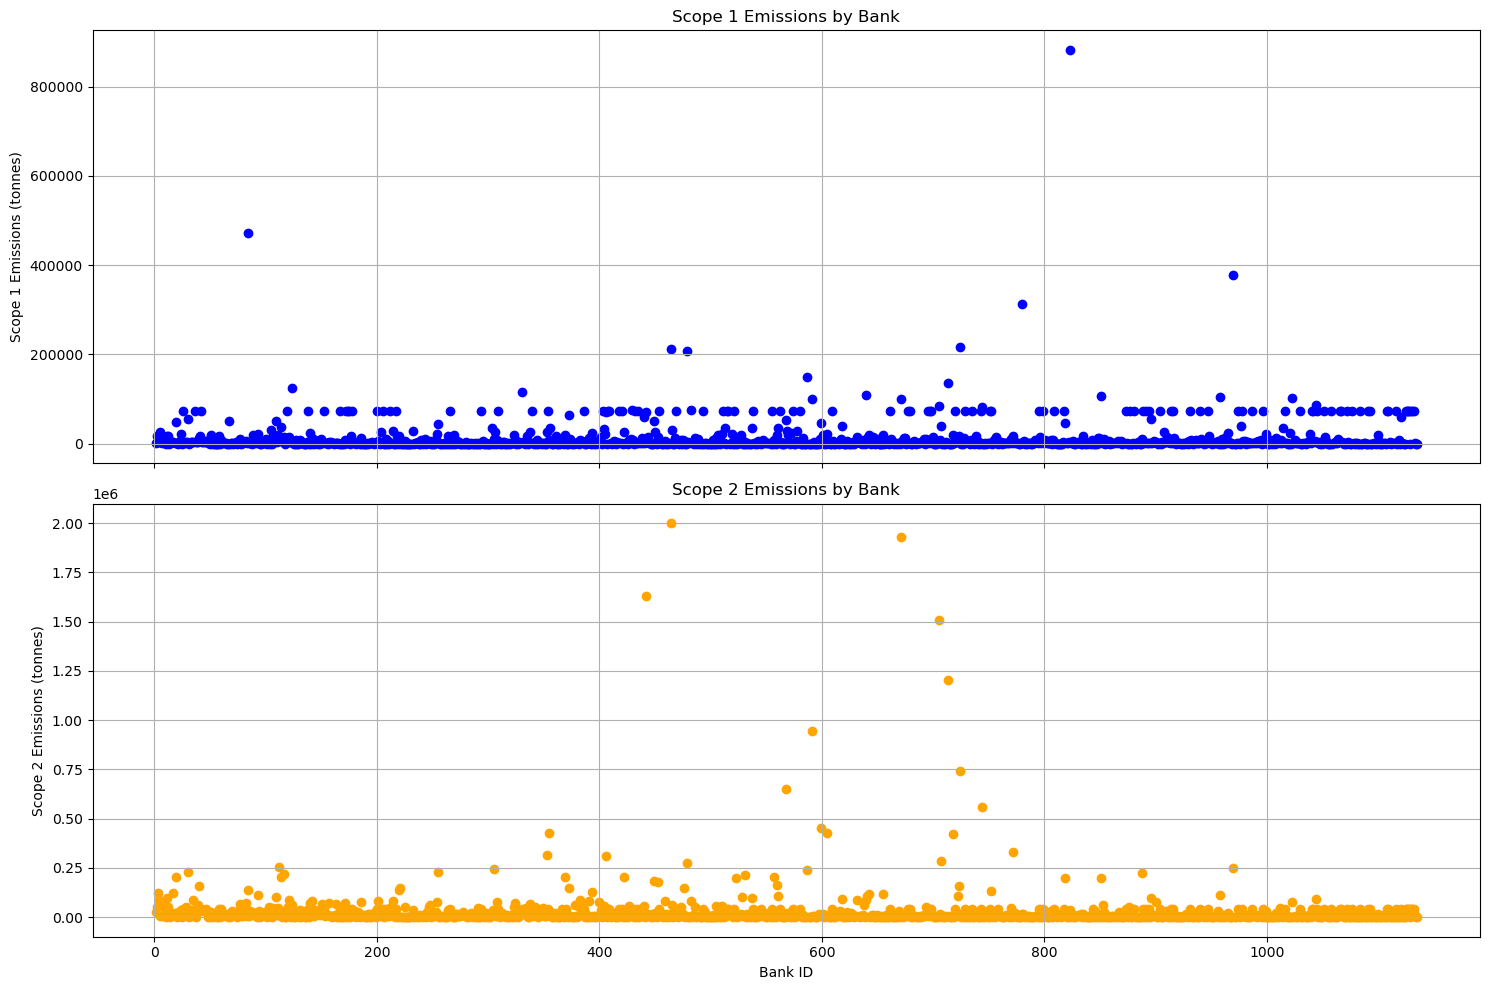

In [26]:
# Create a figure with 2 vertical subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

# Plot Scope 1 emissions
axes[0].scatter(esg_data['id'], esg_data['scope_1_estimated_total'], color='blue')
axes[0].set_ylabel('Scope 1 Emissions (tonnes)')
axes[0].set_title('Scope 1 Emissions by Bank')
axes[0].grid(True)

# Plot Scope 2 emissions
axes[1].scatter(esg_data['id'], esg_data['scope_2_estimated_total'], color='orange')
axes[1].set_xlabel('Bank ID')
axes[1].set_ylabel('Scope 2 Emissions (tonnes)')
axes[1].set_title('Scope 2 Emissions by Bank')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [27]:
#print(df.columns.tolist())

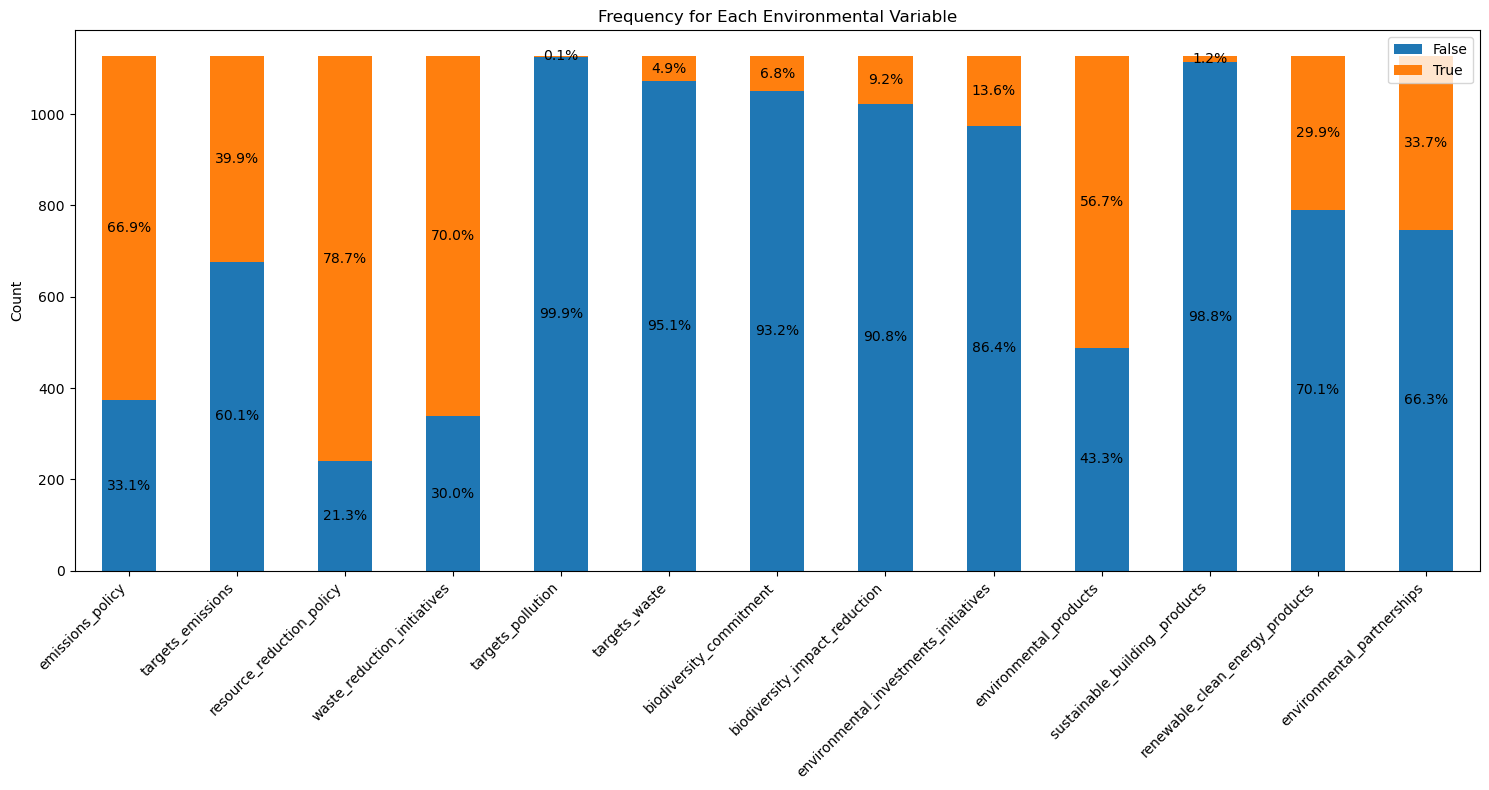

In [28]:
# List of categorical variables
categorical_variables_environmental = [
    'emissions_policy', 'targets_emissions', 'resource_reduction_policy', 'waste_reduction_initiatives',
    'targets_pollution', 'targets_waste', 'biodiversity_commitment', 'biodiversity_impact_reduction',
    'environmental_investments_initiatives', 'environmental_products', 'sustainable_building _products',
    'renewable_clean_energy_products', 'environmental_partnerships']

# Creating counts
counts_categorical_environmental = pd.DataFrame({
    var: esg_data[var].value_counts() for var in categorical_variables_environmental}).T
counts_categorical_environmental = counts_categorical_environmental.rename(columns={False: 'False', True: 'True'})
counts_categorical_environmental = counts_categorical_environmental[['False', 'True']]

# Plotting stacked bar chart 
ax = counts_categorical_environmental.plot(kind='bar', stacked=True, figsize=(15, 8))
ax.set_ylabel("Count")
ax.set_title("Frequency for Each Environmental Variable")

# Adding percentage labels
for i, (var, row) in enumerate(counts_categorical_environmental.iterrows()):
    total = row['False'] + row['True']
    if total > 0:
        false_pct = row['False'] / total * 100
        true_pct = row['True'] / total * 100
        
        ax.text(i, row['False'] / 2, f"{false_pct:.1f}%", 
                ha='center', va='center', color='black', fontsize=10)

        ax.text(i, row['False'] + row['True'] / 2, f"{true_pct:.1f}%", 
                ha='center', va='center', color='black', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 2.4 Social Features

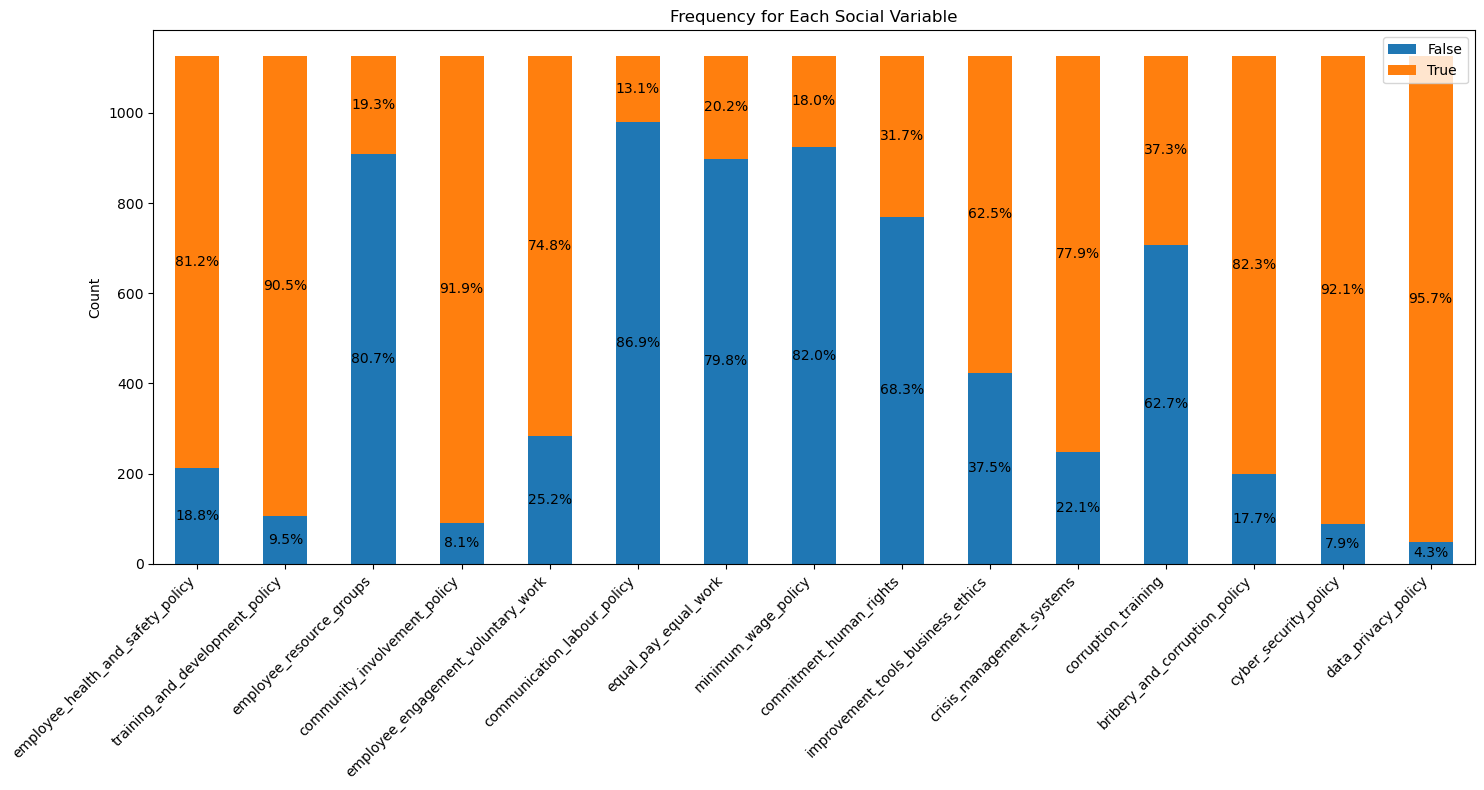

In [29]:
# List of categorical variables
categorical_variables_social = ['employee_health_and_safety_policy', 'training_and_development_policy', 'employee_resource_groups', 'community_involvement_policy', 
                             'employee_engagement_voluntary_work', 'communication_labour_policy', 'equal_pay_equal_work','minimum_wage_policy', 'commitment_human_rights', 
                             'improvement_tools_business_ethics', 'crisis_management_systems', 'corruption_training', 'bribery_and_corruption_policy', 'cyber_security_policy', 
                             'data_privacy_policy']

# Creating counts
counts_categorical_social = pd.DataFrame({
    var: esg_data[var].value_counts() for var in categorical_variables_social}).T
counts_categorical_social = counts_categorical_social.rename(columns={False: 'False', True: 'True'})
counts_categorical_social = counts_categorical_social[['False', 'True']]

# Plotting stacked bar chart 
ax = counts_categorical_social.plot(kind='bar', stacked=True, figsize=(15, 8))
ax.set_ylabel("Count")
ax.set_title("Frequency for Each Social Variable")

# Adding percentage labels
for i, (var, row) in enumerate(counts_categorical_social.iterrows()):
    total = row['False'] + row['True']
    if total > 0:
        false_pct = row['False'] / total * 100
        true_pct = row['True'] / total * 100
        
        ax.text(i, row['False'] / 2, f"{false_pct:.1f}%", 
                ha='center', va='center', color='black', fontsize=10)

        ax.text(i, row['False'] + row['True'] / 2, f"{true_pct:.1f}%", 
                ha='center', va='center', color='black', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 2.5 Governance Features

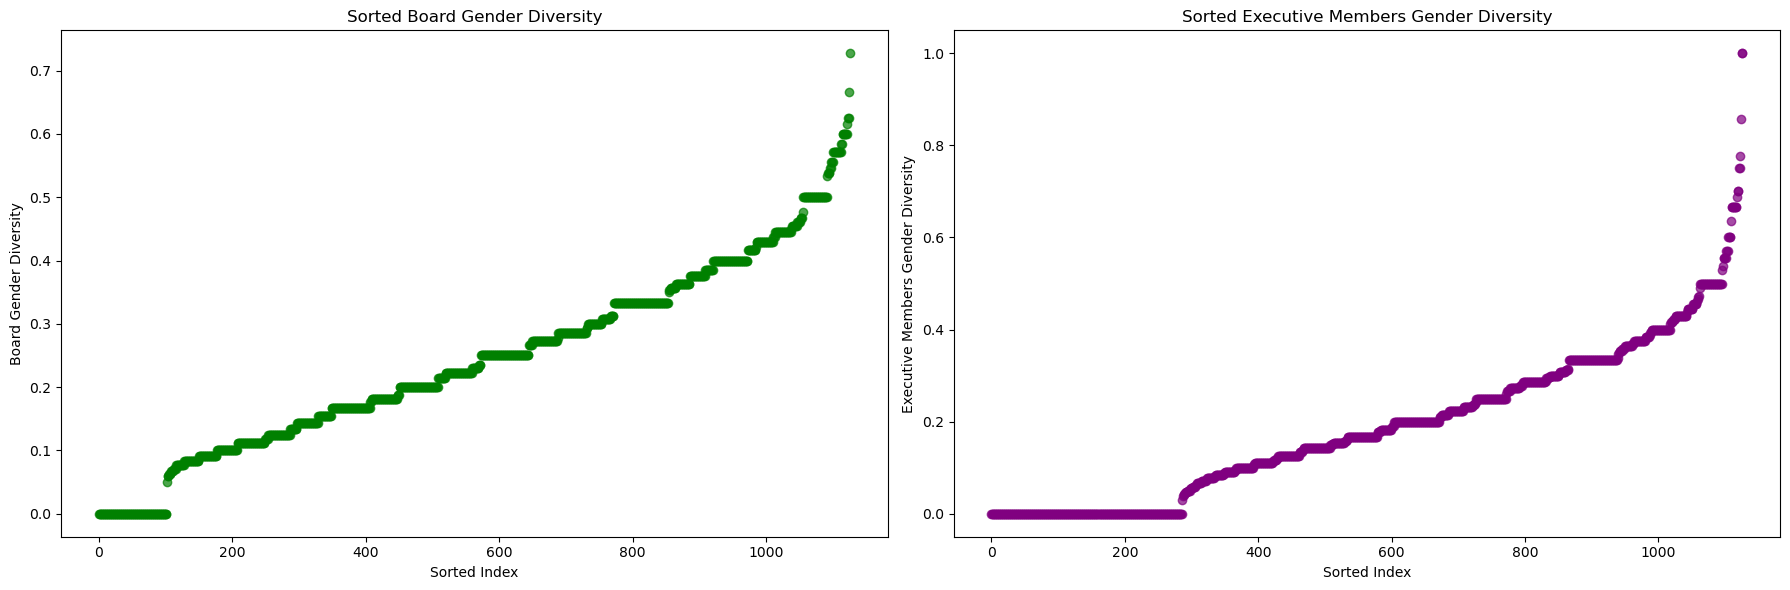

In [30]:
# Sort each variable individually
sorted_board = np.sort(esg_data['board_gender_diversity'].values)
sorted_exec = np.sort(esg_data['executive_members_gender_diversity'].values)

# Create a figure with three subplots in one row
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for Board Gender Diversity
axes[0].scatter(range(len(sorted_board)), sorted_board, color='green', alpha=0.7)
axes[0].set_title('Sorted Board Gender Diversity')
axes[0].set_xlabel('Sorted Index')
axes[0].set_ylabel('Board Gender Diversity')

# Plot for Executive Members Gender Diversity
axes[1].scatter(range(len(sorted_exec)), sorted_exec, color='purple', alpha=0.7)
axes[1].set_title('Sorted Executive Members Gender Diversity')
axes[1].set_xlabel('Sorted Index')
axes[1].set_ylabel('Executive Members Gender Diversity')

plt.tight_layout()
plt.show()

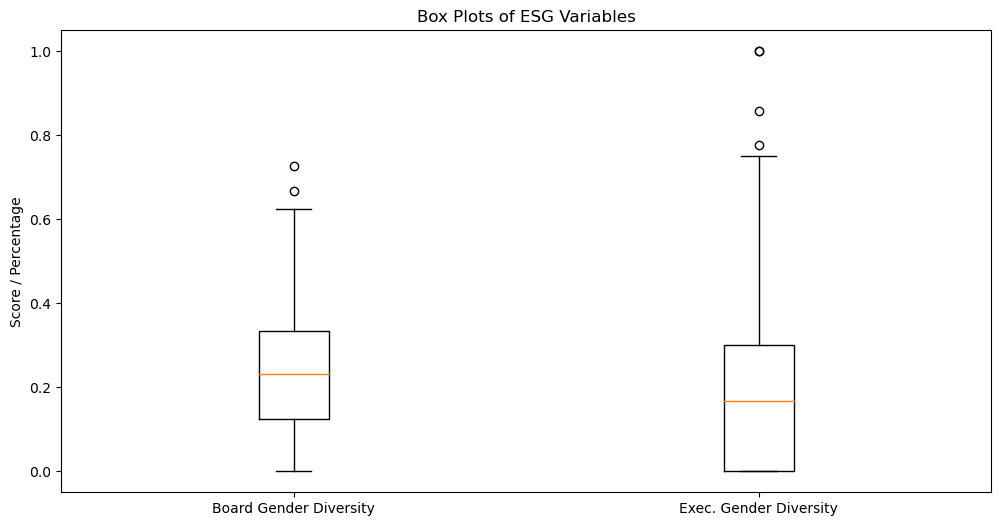

In [31]:
# Extract the three variables into a list for plotting
data_to_plot = [
    #esg_data['csr_strategy_score'],
    esg_data['board_gender_diversity'],
    esg_data['executive_members_gender_diversity']
]

# Create a box plot for each variable on one figure
plt.figure(figsize=(12, 6))
plt.boxplot(data_to_plot, labels=[
    #'CSR Strategy Score', 
    'Board Gender Diversity', 
    'Exec. Gender Diversity'
])
plt.ylabel('Score / Percentage')
plt.title('Box Plots of ESG Variables')
plt.show()

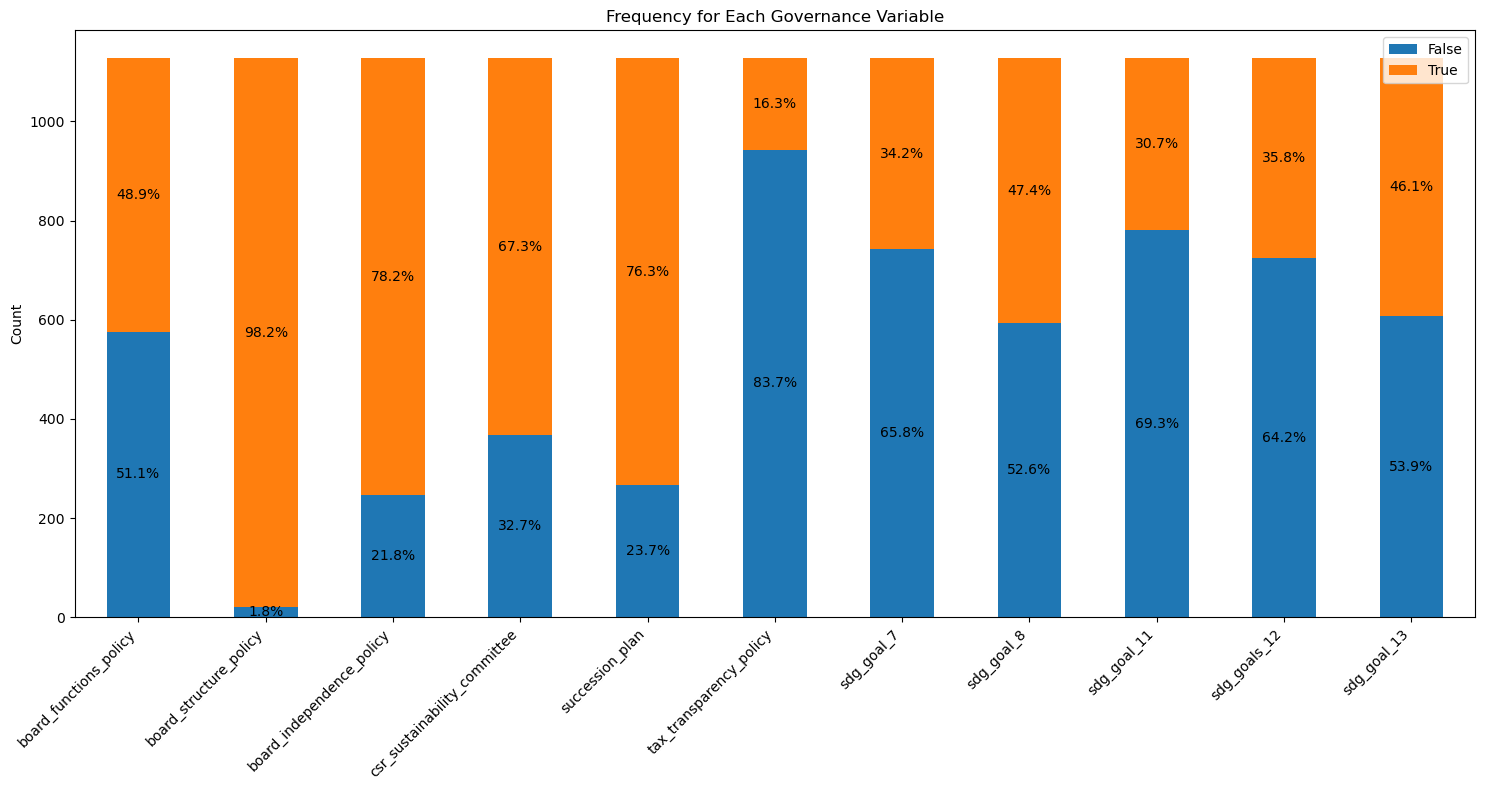

In [32]:
# List of categorical variables
categorical_variables_governance = ['board_functions_policy', 'board_structure_policy','board_independence_policy', 'csr_sustainability_committee', 'succession_plan',
                                    'tax_transparency_policy', 'sdg_goal_7', 'sdg_goal_8', 'sdg_goal_11','sdg_goals_12', 'sdg_goal_13']

# Creating counts
counts_categorical_governance = pd.DataFrame({
    var: esg_data[var].value_counts() for var in categorical_variables_governance}).T
counts_categorical_governance = counts_categorical_governance.rename(columns={False: 'False', True: 'True'})
counts_categorical_governance = counts_categorical_governance[['False', 'True']]

# Plotting stacked bar chart 
ax = counts_categorical_governance.plot(kind='bar', stacked=True, figsize=(15, 8))
ax.set_ylabel("Count")
ax.set_title("Frequency for Each Governance Variable")

# Adding percentage labels
for i, (var, row) in enumerate(counts_categorical_governance.iterrows()):
    total = row['False'] + row['True']
    if total > 0:
        false_pct = row['False'] / total * 100
        true_pct = row['True'] / total * 100
        
        ax.text(i, row['False'] / 2, f"{false_pct:.1f}%", 
                ha='center', va='center', color='black', fontsize=10)

        ax.text(i, row['False'] + row['True'] / 2, f"{true_pct:.1f}%", 
                ha='center', va='center', color='black', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 2.6 Correlation Matrix

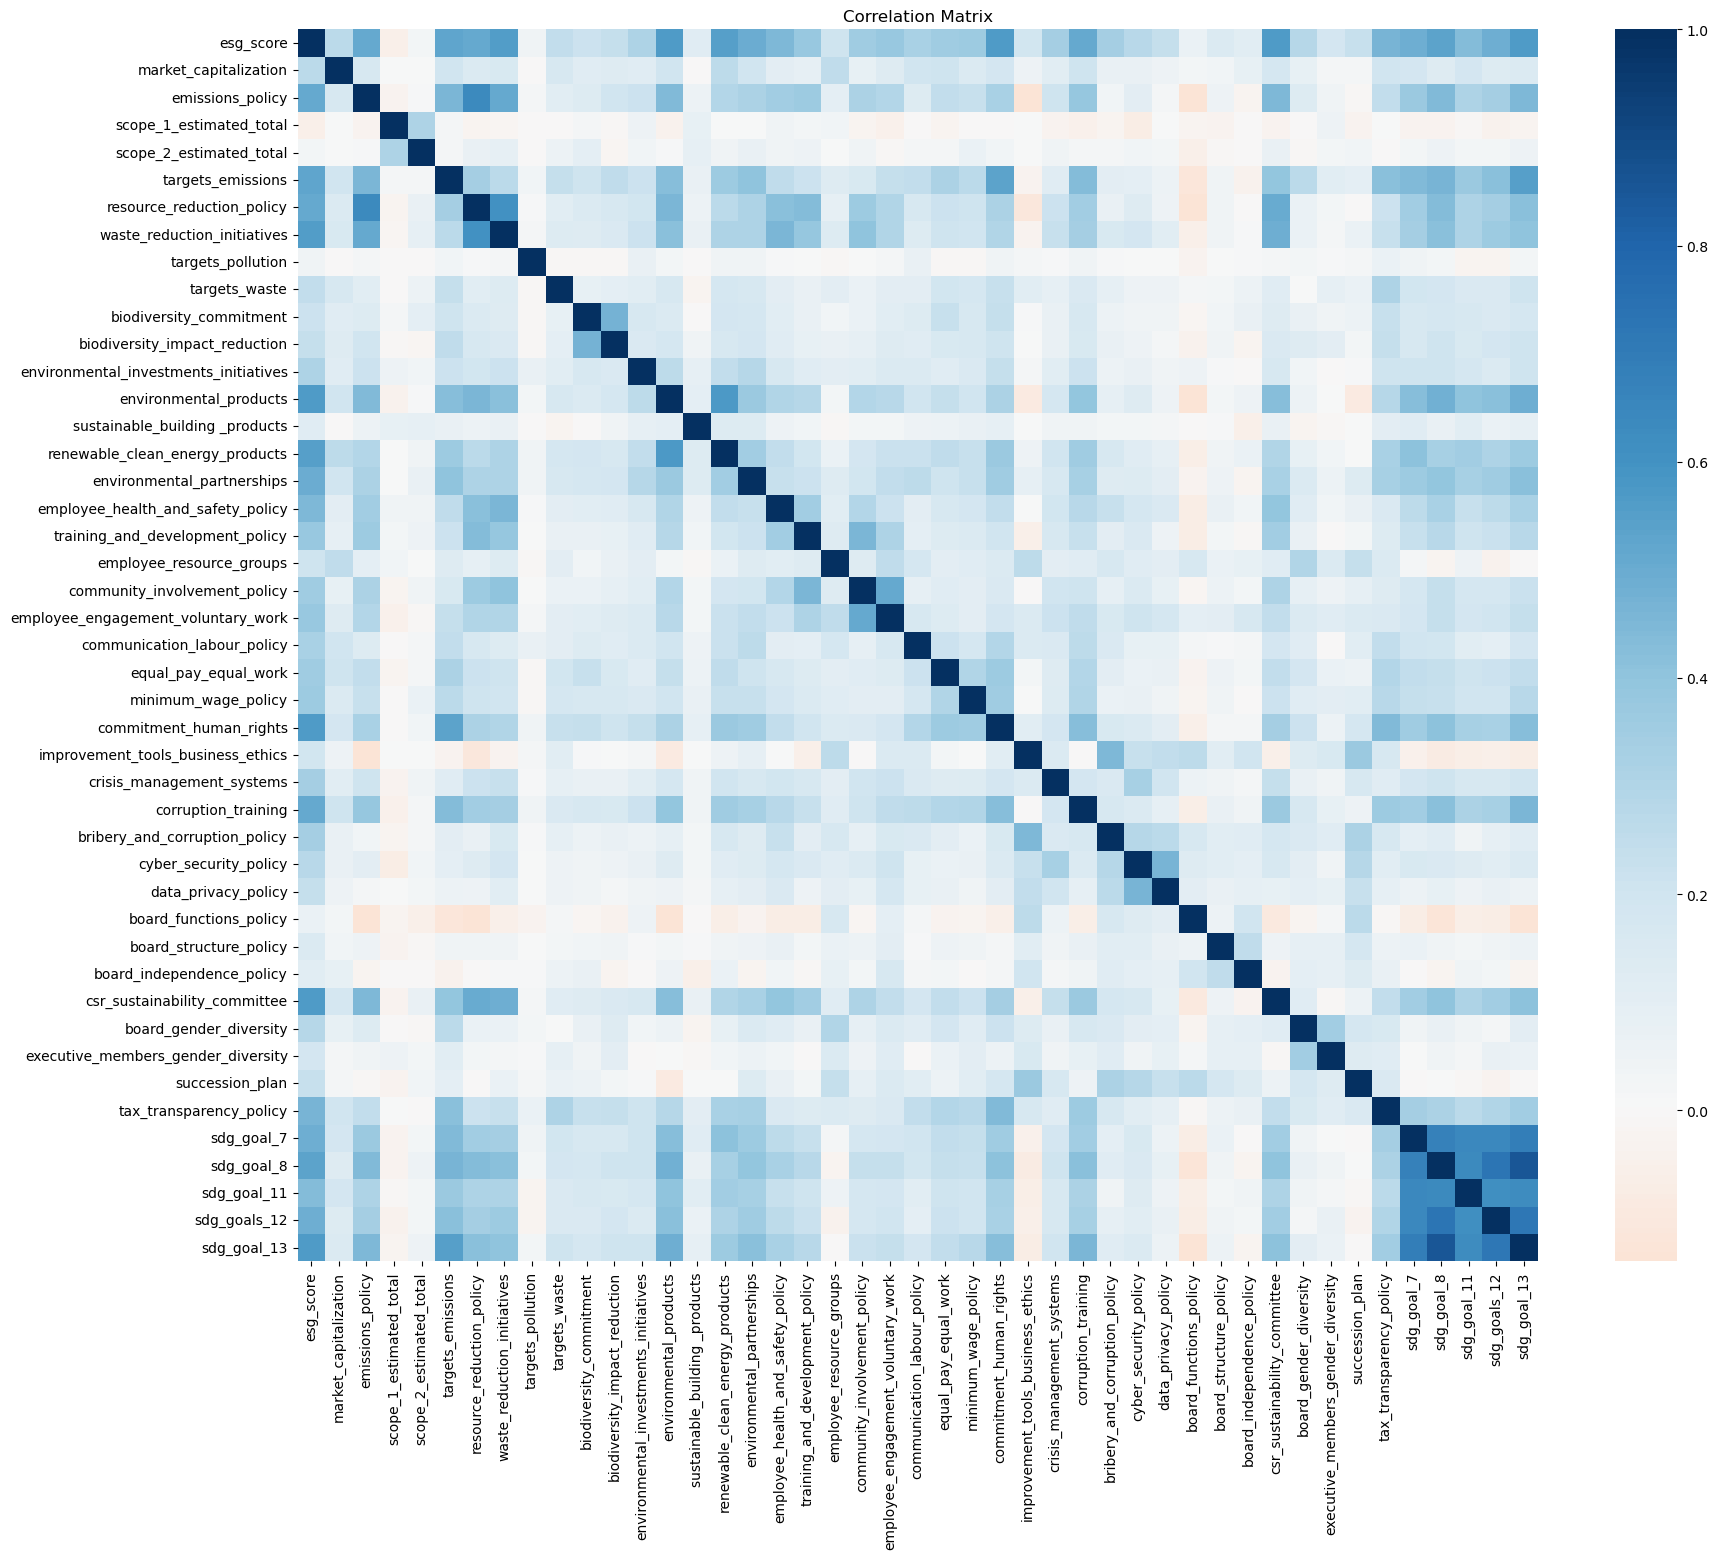

In [33]:
# Working copy without 'id' as it has no meaning
df_corr = esg_data.drop(columns=["id"], errors="ignore").copy()

# Convert all boolean columns to integers 
bool_cols = df_corr.select_dtypes(include="bool").columns
df_corr[bool_cols] = df_corr[bool_cols].astype("int8")

# Move 'esg_score' as the first column 
if "esg_score" in df_corr.columns:
    cols = ["esg_score"] + [c for c in df_corr.columns if c != "esg_score"]
    df_corr = df_corr[cols]

# Compute correlations on all numeric columns
corr_matrix = df_corr.select_dtypes(include="number").corr()

# Plot
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap="RdBu", center=0)
plt.title("Correlation Matrix")
plt.show()

In [34]:
# Final dataset for further modeling 
esg_data_modeling = esg_data.drop(columns=['id', 'name', 'headquarter', 'market_capitalization'])

In [35]:
#esg_data_modeling.head()

In [36]:
#esg_data_modeling.dtypes

# 3. Modeling

## 3.1 Data Preprocessing

In [37]:
# Creating copy of esg_data_modeling for modeling purposes
df = esg_data_modeling.copy()
target_col = "esg_score"
assert target_col in df.columns, f"Target column '{target_col}' not found."

In [38]:
# Definition of target variable and explainable variables
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [39]:
# Creating numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=[np.number, "bool"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object", "category", "string"]).columns.tolist()

In [40]:
# Standardizing variables
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    # drop='if_binary' avoids redundant columns for binary categoricals
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse_output=False)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,  # cleaner names
)

In [41]:
# Fitting preprocessor separately to get transformed feature names
preprocessor.fit(X_train)

def get_transformed_feature_names(prep, num_cols, cat_cols):
    names = []
    if "num" in prep.named_transformers_ and num_cols:
        names.extend(num_cols)
    if "cat" in prep.named_transformers_ and cat_cols:
        ohe = prep.named_transformers_["cat"].named_steps["onehot"]
        names.extend(ohe.get_feature_names_out(cat_cols).tolist())
    return names

transformed_feature_names = get_transformed_feature_names(preprocessor, numeric_cols, categorical_cols)
p_features = len(transformed_feature_names)  

## 3.2 Definition of required functions

In [42]:
# Importance of features
def aggregate_importances(raw_importances: pd.Series,
                          transformed_names: list,
                          num_cols: list,
                          cat_cols: list) -> pd.DataFrame:
    df_imp = pd.DataFrame({
        "feature_transformed": transformed_names,
        "importance": raw_importances.values
    })

    # base dict
    agg = {col: 0.0 for col in list(num_cols) + list(cat_cols)}

    # numeric appear as-is
    for col in num_cols:
        if col in df_imp["feature_transformed"].values:
            agg[col] += df_imp.loc[df_imp["feature_transformed"] == col, "importance"].sum()

    # categorical: sum all columns that start with "col_"
    for col in cat_cols:
        mask = df_imp["feature_transformed"].str.startswith(f"{col}_")
        agg[col] += df_imp.loc[mask, "importance"].sum()

    out = pd.DataFrame({"feature": list(agg.keys()),
                        "importance": list(agg.values())})
    out.sort_values("importance", ascending=False, inplace=True, ignore_index=True)
    return out

In [43]:
# Definition of metrics
def adjusted_r2(r2, n, p):
    denom = max(n - p - 1, 1)  # avoid /0 or negative
    return 1 - (1 - r2) * (n - 1) / denom

def evaluate(pipe, X_tr, y_tr, X_te, y_te, p):
    # --- Training metrics ---
    y_pred_tr = pipe.predict(X_tr)
    r2_tr = r2_score(y_tr, y_pred_tr)
    adj_tr = adjusted_r2(r2_tr, n=len(y_tr), p=p)
    rmse_tr = np.sqrt(mean_squared_error(y_tr, y_pred_tr))
    mae_tr = mean_absolute_error(y_tr, y_pred_tr)
    
    # --- Test metrics ---
    y_pred_te = pipe.predict(X_te)
    r2_te = r2_score(y_te, y_pred_te)
    adj_te = adjusted_r2(r2_te, n=len(y_te), p=p)
    rmse_te = np.sqrt(mean_squared_error(y_te, y_pred_te))
    mae_te = mean_absolute_error(y_te, y_pred_te)

    return {
        "R2_train": r2_tr, "Adj_R2_train": adj_tr, "RMSE_train": rmse_tr, "MAE_train": mae_tr,
        "R2_test": r2_te, "Adj_R2_test": adj_te, "RMSE_test": rmse_te, "MAE_test": mae_te
    }

In [44]:
# Definition of categories for plots
environmental_features = [
    'esg_score', 'emissions_policy', 'scope_1_estimated_total', 'scope_2_estimated_total',
    'targets_emissions', 'resource_reduction_policy', 'waste_reduction_initiatives',
    'targets_pollution', 'targets_waste', 'biodiversity_commitment',
    'biodiversity_impact_reduction', 'environmental_investments_initiatives',
    'environmental_products', 'sustainable_building _products', 'renewable_clean_energy_products',
    'environmental_partnerships'
]

social_features = [
    'employee_health_and_safety_policy', 'training_and_development_policy',
    'employee_resource_groups', 'community_involvement_policy',
    'employee_engagement_voluntary_work', 'communication_labour_policy',
    'equal_pay_equal_work', 'minimum_wage_policy', 'commitment_human_rights',
    'improvement_tools_business_ethics', 'crisis_management_systems',
    'corruption_training', 'bribery_and_corruption_policy', 'cyber_security_policy',
    'data_privacy_policy'
]

governance_features = [
    'board_functions_policy', 'board_structure_policy', 'board_independence_policy',
    'csr_sustainability_committee', 'board_gender_diversity',
    'executive_members_gender_diversity', 'succession_plan',
    'tax_transparency_policy', 'sdg_goal_7', 'sdg_goal_8', 'sdg_goal_11',
    'sdg_goals_12', 'sdg_goal_13'
]

other_features = ['market_cap_bin']

def feature_category(f):
    if f in environmental_features: return 'Environmental'
    if f in social_features:         return 'Social'
    if f in governance_features:     return 'Governance'
    if f in other_features:          return 'Other'
    return 'Other'

# Color map for each category
category_colors = {
    'Environmental': 'green',
    'Social': 'blue',
    'Governance': 'orange',
    'Other': 'gray'
}

# Mapping feature to category
def get_feature_category(feature):
    if feature in environmental_features:
        return 'Environmental'
    elif feature in social_features:
        return 'Social'
    elif feature in governance_features:
        return 'Governance'
    elif feature in other_features:
        return 'Other'
    else:
        return 'Other'


In [45]:
# Plotting functions
mpl.rcParams.update({
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

def _wrap_feature(name: str, width: int = 32) -> str:
    # friendlier wrapping: split on underscores first, then wrap
    name = name.replace("_", " ")
    return "\n".join(textwrap.wrap(str(name), width=width))

def _colors_for(df):
    return [category_colors[feature_category(f)] for f in df["feature"]]

def _hbar(ax, df, title, label_wrap=32, value_font=8, ytick_font=9, pad_frac=0.15):
    if df.empty:
        ax.set_title(title + " (no features)")
        ax.axis("off")
        return

    df = df.sort_values("importance", ascending=False).reset_index(drop=True)
    y = range(len(df))
    cols = _colors_for(df)
    vals = df["importance"].values
    feats = [_wrap_feature(f, width=label_wrap) for f in df["feature"]]

    xmax = max(vals) * (1 + pad_frac)
    ax.set_xlim(0, xmax)

    bars = ax.barh(y, vals, color=cols, edgecolor="black")
    ax.invert_yaxis()
    ax.set_yticks(y)
    ax.set_yticklabels(feats, fontsize=ytick_font)  # <--- control font size here
    ax.set_title(title)
    ax.set_xlabel("Importance")
    ax.xaxis.grid(True, linestyle=":", alpha=0.45)
    ax.set_axisbelow(True)
    for b, v in zip(bars, vals):
        ax.text(min(v * 1.01, xmax * 0.995),
                b.get_y() + b.get_height()/2,
                f"{v:.3f}", va="center", ha="left", fontsize=value_font)

def plot_importances_final(model_name, agg_per_model, overall_k=20, per_cat_k=7, save=True):
    agg = agg_per_model[model_name].dropna(subset=["importance"]).copy()

    overall = agg.nlargest(overall_k, "importance")
    env_df  = agg[agg["feature"].isin(environmental_features)].nlargest(per_cat_k, "importance")
    soc_df  = agg[agg["feature"].isin(social_features)].nlargest(per_cat_k, "importance")
    gov_df  = agg[agg["feature"].isin(governance_features)].nlargest(per_cat_k, "importance")

    # Layout: overall (left, full height), categories stacked on the right
    fig = plt.figure(figsize=(20, 11))
    gs = fig.add_gridspec(3, 2, width_ratios=[1.5, 1.4], height_ratios=[1, 1, 1], hspace=0.35, wspace=0.35)

    ax_overall = fig.add_subplot(gs[:, 0])
    ax_env     = fig.add_subplot(gs[0, 1])
    ax_soc     = fig.add_subplot(gs[1, 1])
    ax_gov     = fig.add_subplot(gs[2, 1])

    _hbar(ax_overall, overall, f"Top {len(overall)} Overall", label_wrap=44, value_font=8, ytick_font=10, pad_frac=0.18)
    _hbar(ax_env, env_df,   f"Environmental (Top {len(env_df)})", label_wrap=30, value_font=8, ytick_font=7)
    _hbar(ax_soc, soc_df,   f"Social (Top {len(soc_df)})",         label_wrap=30, value_font=8, ytick_font=7)
    _hbar(ax_gov, gov_df,   f"Governance (Top {len(gov_df)})",     label_wrap=30, value_font=8, ytick_font=7)

    # Legend inside the overall panel (lower-right)
    handles = [plt.Rectangle((0,0),1,1, color=c) for c in category_colors.values()]
    ax_overall.legend(handles, category_colors.keys(), title="Category",
                      loc="lower right", frameon=True, framealpha=0.9)

    # Give extra room on the left for long labels
    fig.subplots_adjust(left=0.33)
    fig.suptitle(f"Feature Importances — {model_name}", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])

    if save:
        fname = f"importances_{model_name}_final.png"
        fig.savefig(fname, dpi=250, bbox_inches="tight")
        print(f"Saved: {fname}")
    plt.show()


## 3.2 Models

In [46]:
# First approach: Simple models without hypterparameter tuning
models = {
    "OLS": Pipeline(steps=[
        ("prep", preprocessor),
        ("model", LinearRegression())
    ]),
    "Lasso": Pipeline(steps=[
        ("prep", preprocessor),
        ("model", LassoCV(cv=5, random_state=42, n_alphas=100, max_iter=10000))
    ]),
    "DecisionTree": Pipeline(steps=[
        ("prep", preprocessor),
        ("model", DecisionTreeRegressor(random_state=42))
    ]),
    "RandomForest": Pipeline(steps=[
        ("prep", preprocessor),
        ("model", RandomForestRegressor(
            n_estimators=500, random_state=42, n_jobs=-1
        ))
    ]),
    "GradientBoosting": Pipeline(steps=[
        ("prep", preprocessor),
        ("model", GradientBoostingRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.8,
            random_state=42
        ))
    ]),
}

In [47]:
# Second approach: Models including hyperparameter tuning

# Preparing pipelines
ols_pipe = Pipeline([("prep", preprocessor), ("model", LinearRegression())])

lasso_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", LassoCV(
        alphas=np.logspace(-4, 1, 100),
        cv=5, random_state=42, max_iter=10000
    ))
])

dt_pipe = Pipeline([("prep", preprocessor), ("model", DecisionTreeRegressor(random_state=42))])

rf_pipe = Pipeline([("prep", preprocessor), ("model", RandomForestRegressor(random_state=42, n_jobs=-1))])

gbr_pipe = Pipeline([("prep", preprocessor), ("model", GradientBoostingRegressor(random_state=42))])

# Model parameters
param_spaces = {
    "DecisionTree": {
        "model__max_depth": randint(2, 30),
        "model__min_samples_split": randint(2, 30),
        "model__min_samples_leaf": randint(1, 15),
        "model__max_features": ["sqrt", "log2", None]
    },
    "RandomForest": {
        "model__n_estimators": randint(100, 600),
        "model__max_depth": randint(3, 15),
        "model__min_samples_split": randint(2, 50),
        "model__min_samples_leaf": randint(1, 20),
        "model__max_features": ["sqrt", "log2", 0.3, 0.5, None],
        "model__bootstrap": [True]
    },
    "GradientBoosting": {
        "model__n_estimators": randint(300, 1001),
        "model__learning_rate": uniform(0.01, 0.19),   
        "model__max_depth": randint(2, 6),
        "model__subsample": uniform(0.6, 0.4),         
        "model__min_samples_split": randint(2, 20),
        "model__min_samples_leaf": randint(1, 10),
        "model__max_features": ["sqrt", "log2", 0.3, 0.5, None],
        "model__loss": ["squared_error"]               
    },
}

# Building searches
search_cfg = dict(
    n_iter=50,                
    cv=5,
    scoring="neg_mean_squared_error",  
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True
)

models = {
    "OLS": ols_pipe,
    "Lasso": lasso_pipe,
    "DecisionTree": dt_pipe,
    "RandomForest": rf_pipe,
    "GradientBoosting": gbr_pipe,
}

tuned_best = {}      # best estimators after tuning 
cv_summaries = {}    # store best params/scores

for name, base_pipe in models.items():
    if name in param_spaces:
        search = RandomizedSearchCV(
            estimator=base_pipe,
            param_distributions=param_spaces[name],
            **search_cfg
        )
        search.fit(X_train, y_train)
        tuned_best[name] = search.best_estimator_
        # convert neg MSE to RMSE for readability
        best_rmse = np.sqrt(-search.best_score_)
        cv_summaries[name] = {
            "best_params": search.best_params_,
            "cv_best_rmse": best_rmse
        }
        print(f"\n{name} best CV RMSE: {best_rmse:.4f}")
        print(f"{name} best params: {search.best_params_}")
    else:
        # OLS & LassoCV: fit directly
        base_pipe.fit(X_train, y_train)
        tuned_best[name] = base_pipe
        cv_summaries[name] = {"best_params": "N/A (closed-form / LassoCV)", "cv_best_rmse": None}

Fitting 5 folds for each of 50 candidates, totalling 250 fits

DecisionTree best CV RMSE: 12.2936
DecisionTree best params: {'model__max_depth': 22, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 16}
Fitting 5 folds for each of 50 candidates, totalling 250 fits

RandomForest best CV RMSE: 9.8927
RandomForest best params: {'model__bootstrap': True, 'model__max_depth': 8, 'model__max_features': 0.3, 'model__min_samples_leaf': 3, 'model__min_samples_split': 2, 'model__n_estimators': 326}
Fitting 5 folds for each of 50 candidates, totalling 250 fits

GradientBoosting best CV RMSE: 9.3939
GradientBoosting best params: {'model__learning_rate': 0.01700851999736123, 'model__loss': 'squared_error', 'model__max_depth': 2, 'model__max_features': 'log2', 'model__min_samples_leaf': 2, 'model__min_samples_split': 6, 'model__n_estimators': 524, 'model__subsample': 0.8537405378805455}


In [48]:
# Training
agg_per_model = {}
top20_per_model = {}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    model = pipe.named_steps["model"]

    if isinstance(model, LinearRegression):
        raw = pd.Series(np.abs(model.coef_).ravel(), index=transformed_feature_names)
    elif isinstance(model, LassoCV):
        raw = pd.Series(np.abs(model.coef_).ravel(), index=transformed_feature_names)
    elif hasattr(model, "feature_importances_"):
        raw = pd.Series(model.feature_importances_.ravel(), index=transformed_feature_names)
    else:
        raise ValueError(f"Unsupported model for importance extraction: {name}")

    if raw.sum() > 0:
        raw = raw / raw.sum()

    # Full aggregated importances
    agg = aggregate_importances(raw, transformed_feature_names, numeric_cols, categorical_cols)
    agg_per_model[name] = agg

    # Top 20 for tables
    top20_per_model[name] = agg.head(20)

## 3.3 Feature importances

/var/folders/vj/sjmn2kzs23z7gt482qgjc9y80000gn/T/ipykernel_58656/3804709448.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.97])


Saved: importances_OLS_final.png


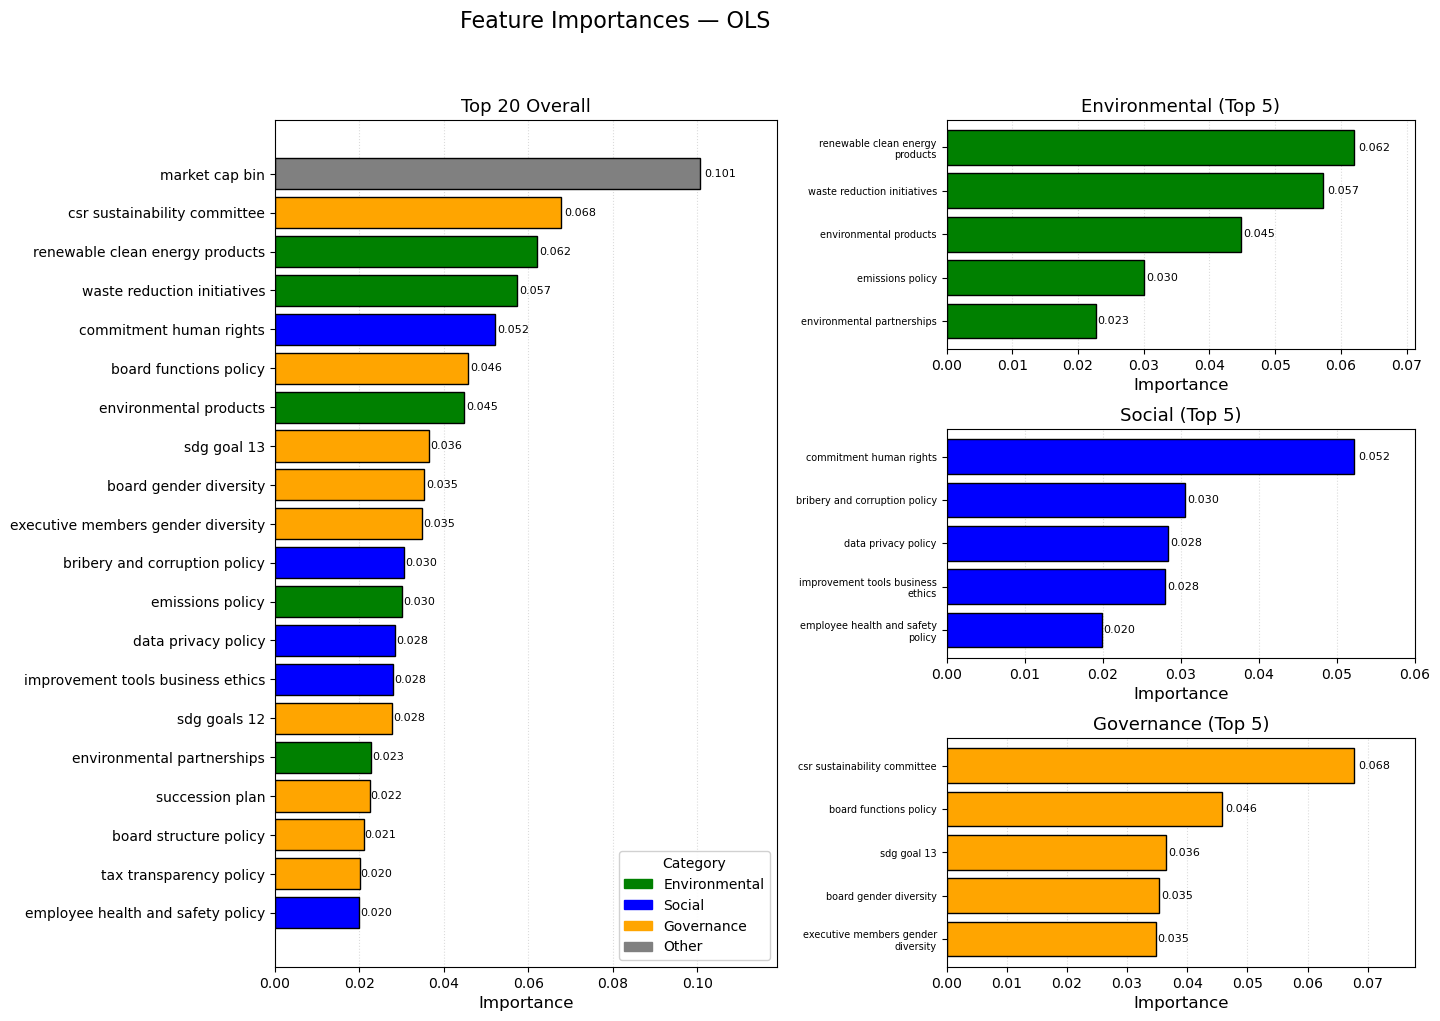

/var/folders/vj/sjmn2kzs23z7gt482qgjc9y80000gn/T/ipykernel_58656/3804709448.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.97])


Saved: importances_Lasso_final.png


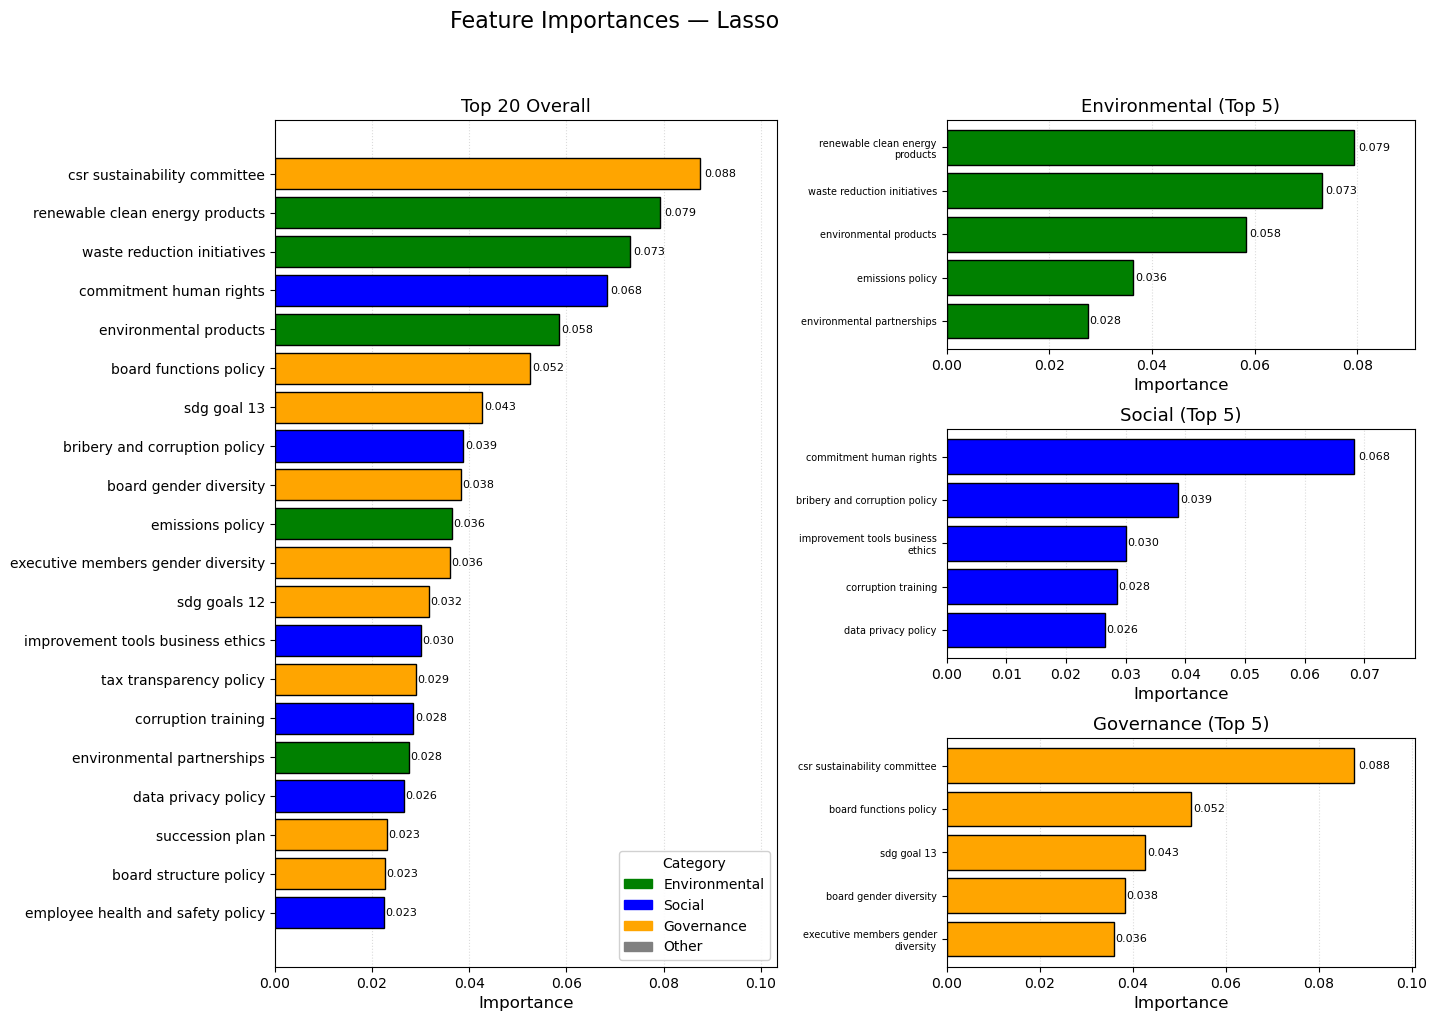

/var/folders/vj/sjmn2kzs23z7gt482qgjc9y80000gn/T/ipykernel_58656/3804709448.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.97])


Saved: importances_DecisionTree_final.png


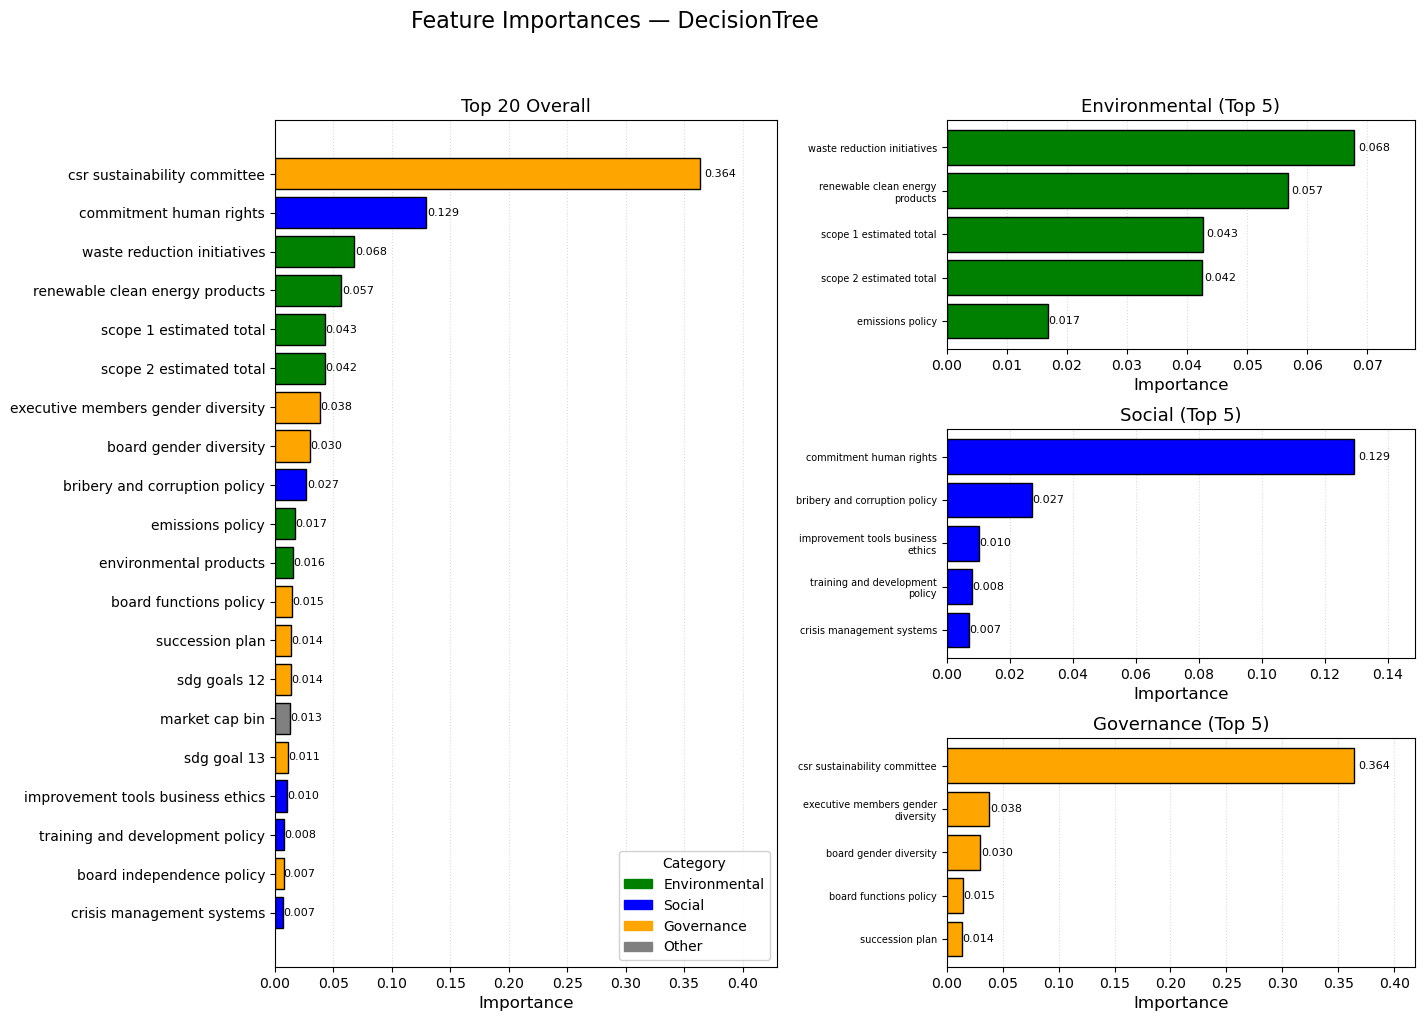

/var/folders/vj/sjmn2kzs23z7gt482qgjc9y80000gn/T/ipykernel_58656/3804709448.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.97])


Saved: importances_RandomForest_final.png


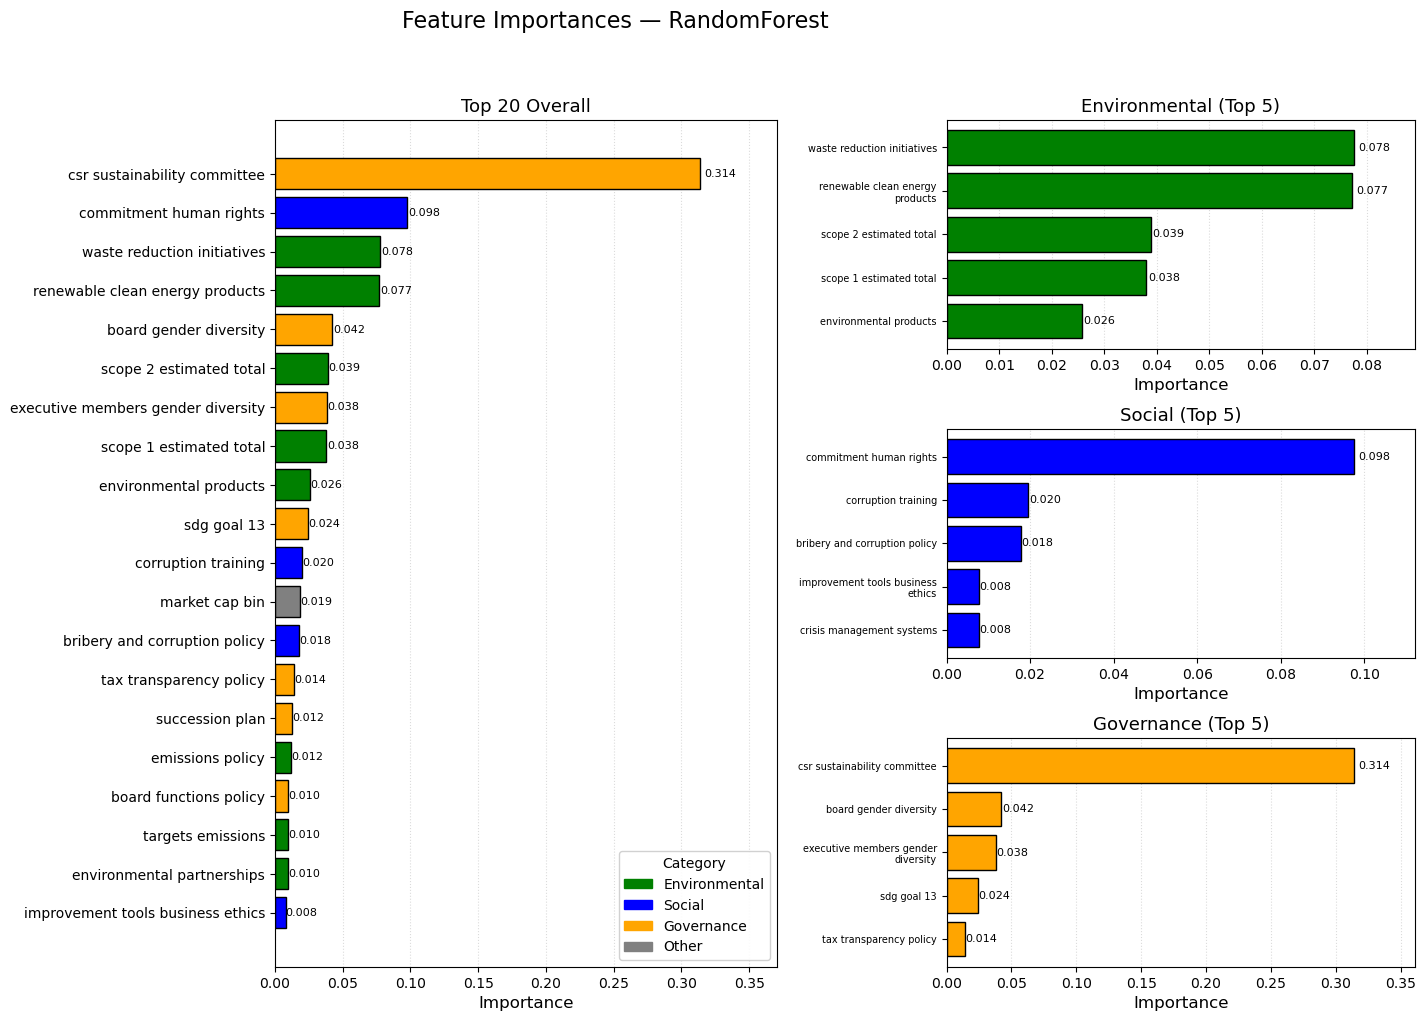

/var/folders/vj/sjmn2kzs23z7gt482qgjc9y80000gn/T/ipykernel_58656/3804709448.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.97])


Saved: importances_GradientBoosting_final.png


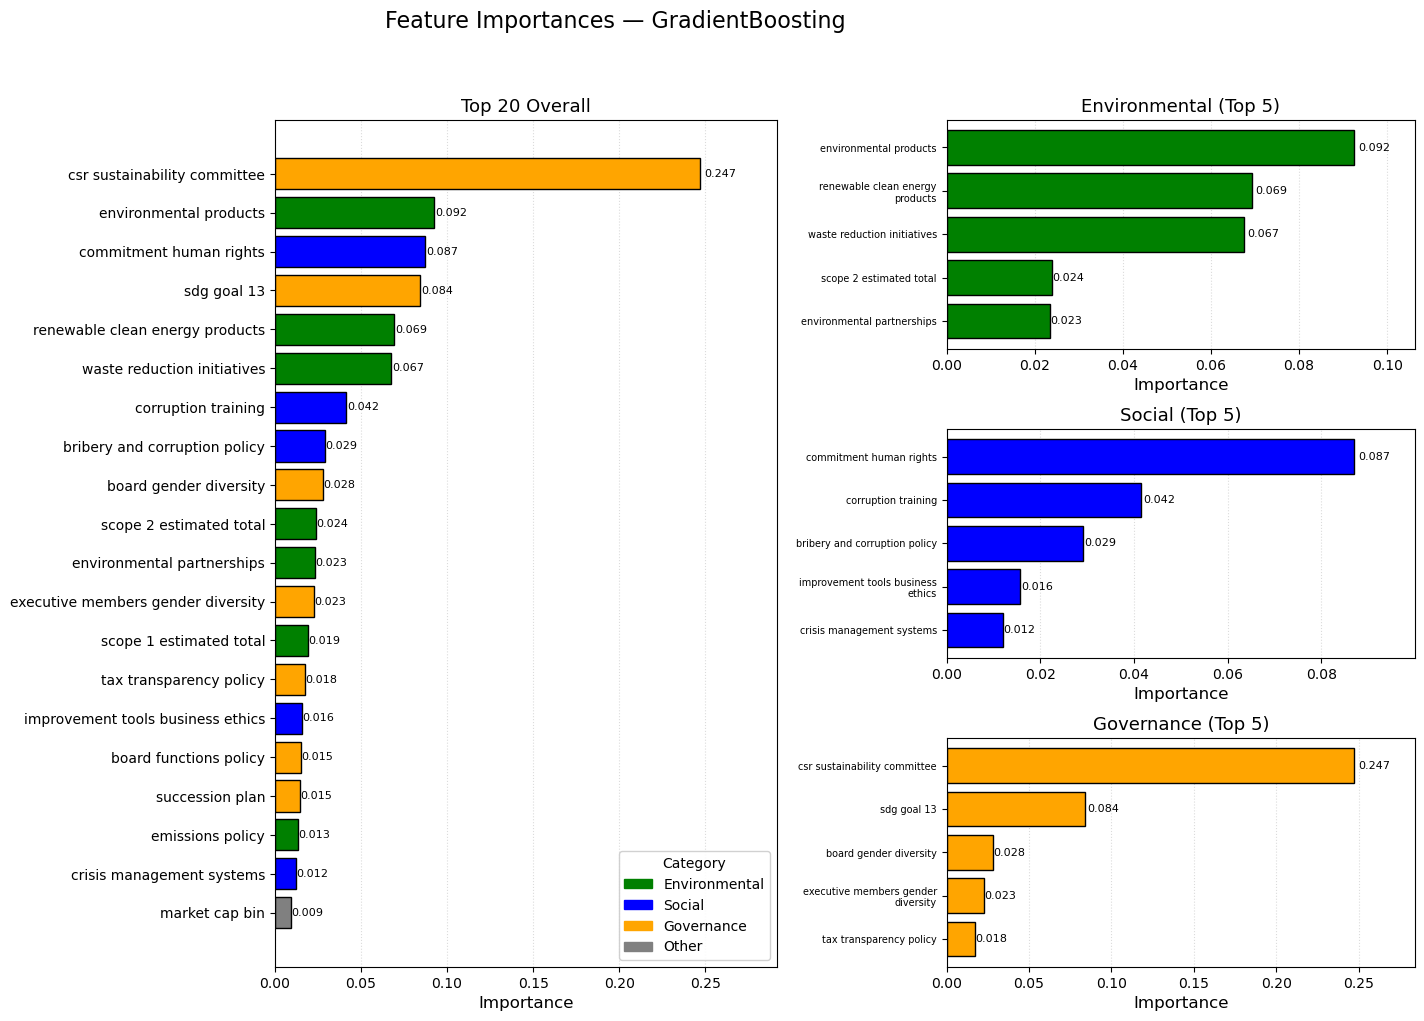

In [49]:
for mdl in agg_per_model:
    plot_importances_final(mdl, agg_per_model, overall_k=20, per_cat_k=5, save=True)

## 3.4 Evaluation metrics

In [50]:
metrics_rows = []

for name, pipe in tuned_best.items():
    pipe.fit(X_train, y_train)
    m = evaluate(pipe, X_train, y_train, X_test, y_test, p_features)
    m["Model"] = name
    metrics_rows.append(m)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_rows)[[
    "Model",
    "R2_train", "Adj_R2_train", "RMSE_train", "MAE_train",
    "R2_test", "Adj_R2_test", "RMSE_test", "MAE_test"
]]

# Round numbers for readability
metrics_df = metrics_df.round(3)

# Print neatly
print("\n=== Model Metrics (Train vs Test) ===")
print(metrics_df.to_string(index=False))


=== Model Metrics (Train vs Test) ===
           Model  R2_train  Adj_R2_train  RMSE_train  MAE_train  R2_test  Adj_R2_test  RMSE_test  MAE_test
             OLS     0.780         0.767       9.095      7.331    0.733        0.661     10.412     8.399
           Lasso     0.775         0.763       9.180      7.366    0.729        0.656     10.487     8.558
    DecisionTree     0.768         0.755       9.322      7.417    0.552        0.431     13.487    10.849
    RandomForest     0.863         0.855       7.173      5.853    0.706        0.626     10.926     9.095
GradientBoosting     0.798         0.787       8.705      7.000    0.732        0.659     10.441     8.510
